In [1]:
%reload_ext autoreload
%autoreload 2
# from pywinusb import hid
import numpy as np
from lib.DMDpycrafter import *
from lib.Hadamard_lib.DMD_pattern_gen import *

from skimage import io
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [3]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2

In [4]:
circle = create_circular_mask(1600, 2560, radius=461) # 53 laser 0.8 mm, 461 7mm pinhole size
circle[int(1600/2-25):int(1600/2+25), :] = 1
circle[:,int(2560/2-25):int(2560/2+25)] = 1
# circle = np.zeros((1600, 2560))==0
# circle = checkerboard((2, 2))==True

tilew = np.tile([[0]], reps=[20, 20])
tileb = np.tile([[1]], reps=[20, 20])
tilew = np.tile([[0]], reps=[0, 20])
tileb = np.tile([[1]], reps=[20, 20])
v1 = np.vstack([tilew, tileb])
v2 = np.vstack([tileb, tilew])
v = np.hstack([v1, v2])

# circle = np.tile(v, reps=[40, 64])
square = np.ones((1600, 2560)).astype(bool)
images=[~square]
# images = [~create_circular_mask(1600, 2560, radius=600)]
img_index_seq = list(range(len(images)))

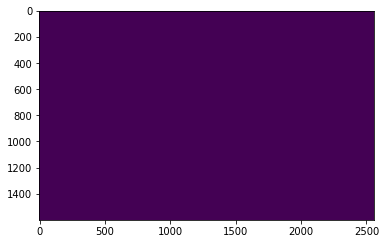

In [14]:
plt.imshow(images[0])

In [15]:
from PIL import ImageDraw, ImageFont
def num_image(num):
    img = PIL.Image.new(mode='L', size=(2560, 1600))
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(font='arial', size=1000)
    d.text((1280-500, 800-500), str(num), fill=(255), font=fnt)
    return img.__array__().astype(bool)

In [16]:
def getidx(image_index):
    merged_idx = image_index//24
    bitplane_idx = image_index - merged_idx*24
    return merged_idx, bitplane_idx

In [17]:
def line_pattern(rows=2560, cols=1600, scale=1):
    # tiling_factor = rows//(4*scale) + 1
    tiling_factor = max(rows, cols)//(4*scale) + 1

    p00 = np.array([[0, 0, 1, 1]]).repeat(scale, axis=1).repeat(max(rows, cols), axis=0)
    p00 = np.tile(p00, tiling_factor).astype(bool)
    
    p90 = np.array([[1, 0, 0, 1]]).repeat(scale, axis=1).repeat(max(rows, cols), axis=0)
    p90 = np.tile(p90, tiling_factor).astype(bool)
    
    p180 = np.array([[1, 1, 0, 0]]).repeat(scale, axis=1).repeat(max(rows, cols), axis=0)
    p180 = np.tile(p180, tiling_factor).astype(bool)

    return [np.zeros((cols, rows)).astype(bool), p00.T[:cols, :rows], p90.T[:cols, :rows], p180.T[:cols, :rows]]

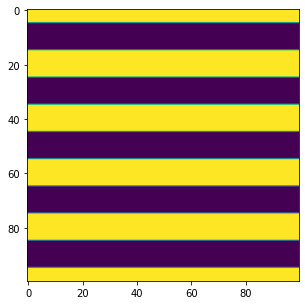

In [96]:
had = hadamard_dmd(rows=2560, cols=1600, n=19, separation=4, scale_factor=2)
images = [~had[:, :, i].astype(bool) for i in range(had.shape[-1])]


images = line_pattern(scale=5)
# images = images[1:3]
img_index_seq = list(range(len(images)))


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plt.imshow(images[2][:100, :100])

In [18]:
dmd = DMDhid()
dmd.stopsequence()
dmd.changemode(3)
exposure=[2500000]*len(images)
dark_time=[0]*len(images)
trigger_in=[False]*len(images)
trigger_out=[0]*len(images)
dmd.defsequence(images,exposure,trigger_in,dark_time,trigger_out,0, img_index_seq)


merging...
encoding...
Compressed data size | master : 6452 | slave : [6452]
uploading...
0 13
0 13


In [19]:
dmd.startsequence()

In [99]:
dmd.stopsequence()

In [42]:
# fujikura bundle fiber efficiency
# 9.16x
# 7.6 um pixel
# radius(pixels) befor(mW) after(mW)
# 200 0.113 0.039
# 300 0.307 0.153
# 400 0.564 0.287
# 500 0.854 0.455
# 600 1.250 0.685

400

In [83]:
# 20x 0.4 NA, 165 mm tube
w = 0.5
Mobj = 16.5 #20*165/200
min_pixel_dmd = 7.6 / Mobj
T = min_pixel_dmd*4
v = 1/T
NA = 0.4
n = 1
fc = 2*NA/w 
vn = v / fc

lateral = 0.61*w/NA
axial = 2*w*n / NA**2

print(f'Mobj : {Mobj} x | NA : {NA} | min_pixel_dmd : {min_pixel_dmd} um')
print(f'T (4 dmd pixel) : {T} um| v (1/T): {v} um-1| fc : {fc} | vn (v/fc) : {vn}')
print(f'Sectioning FWHM : {0.04407*w / vn / (1-vn) / np.sin(0.5*np.arcsin(NA/n))**2 * 2} | lateral : {lateral} um | axial : {axial} um')

Mobj : 16.5 x | NA : 0.4 | min_pixel_dmd : 0.4606060606060606 um
T (4 dmd pixel) : 1.8424242424242423 um| v (1/T): 0.5427631578947368 um-1| fc : 1.6 | vn (v/fc) : 0.3392269736842105
Sectioning FWHM : 4.7100187239350815 | lateral : 0.7625 um | axial : 6.249999999999999 um


In [84]:
# 0.5 NA, 6.25x zoom cradle
w = 0.5
Mobj = 6.25
min_pixel_dmd = 4 / Mobj # 4 um core size
T = min_pixel_dmd*4
v = 1/T
NA = 0.5
n = 1
fc = 2*NA/w 
vn = v / fc

lateral = 0.61*w/NA
axial = 2*w*n / NA**2

print(f'Mobj : {Mobj} x | NA : {NA} | min_pixel_dmd : {min_pixel_dmd} um')
print(f'T (4 dmd pixel) : {T} um| v (1/T): {v} um-1| fc : {fc} | vn (v/fc) : {vn}')
print(f'Sectioning FWHM : {0.04407*w / vn / (1-vn) / np.sin(0.5*np.arcsin(NA/n))**2 * 2} | lateral : {lateral} um | axial : {axial} um')

Mobj : 6.25 x | NA : 0.5 | min_pixel_dmd : 0.64 um
T (4 dmd pixel) : 2.56 um| v (1/T): 0.390625 um-1| fc : 2.0 | vn (v/fc) : 0.1953125
Sectioning FWHM : 4.185942855772206 | lateral : 0.61 um | axial : 4.0 um


In [100]:
name = 'image_2022-07-06T17-00-43.867_0.tif'
simimg = io.imread(os.path.join('./thorcam/', name))

In [101]:
def to16bit(image):
    image = (image - image.min()) / (image.max() - image.min())
    image *= 2**16-1
    return image

def sim_avg(image):
    d0x = image[1, :, :].astype(np.float32)
    d90x = image[2, :, :].astype(np.float32)
    d180x = image[3, :, :].astype(np.float32)

    ximg = 0.5 * np.sqrt((2*d90x - d0x - d180x)**2 + (d180x - d0x)**2)
    return ximg

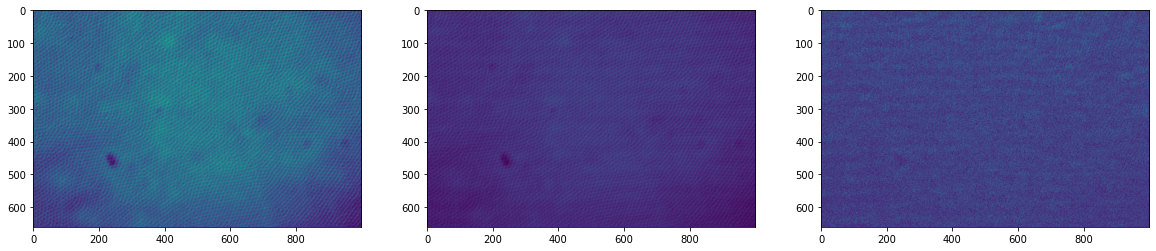

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axes = axes.ravel()
img_st = 1500
img_ed = 2500
axes[0].imshow(simimg[0, :, :][img_st:img_ed, img_st:img_ed])
axes[1].imshow(simimg[1, :, :][img_st:img_ed, img_st:img_ed])
axes[2].imshow(sim_avg(simimg)[img_st:img_ed, img_st:img_ed])

In [103]:
io.imsave('./thorcam/original.tif', to16bit(simimg[0, :, :]))
io.imsave('./thorcam/sim.tif', to16bit(sim_avg(simimg)))

In [ ]:
aa = io.imread('1 img_neg 10x.tiff')
aa = np.moveaxis(aa, [0, 1, 2], [2, 0, 1])
cal = io.imread('1 calb 10x defocus.tiff')
cal = np.moveaxis(cal, [0, 1, 2], [2, 0, 1])
hh = hadamard_bincode_nopermutation(11)

imp = np.dot(aa[:, :, :12], hh.T)
calibration = np.dot(cal[:, :, :12], hh.T)
res = calibration*imp

had_res = res.mean(axis=-1)/res.mean(axis=-1).max()*60000
ori_res = aa.mean(axis=-1)/aa.mean(axis=-1).max()*60000

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
axes = axes.ravel()
axes[0].imshow(imp[:, :, 1])
axes[1].imshow(calibration[:, :, 1])
axes[2].imshow(np.where(calibration[:, :, 1] >=0, calibration[:, :, 1]**2, np.log(calibration[:, :, 1])))
axes[3].imshow(aa.mean(axis=-1))
axes[4].imshow(res.mean(axis=-1))

In [ ]:
io.imsave('hada.tif', had_res.astype(np.uint16))
io.imsave('ori.tif', ori_res.astype(np.uint16))

In [ ]:
# hadamard microscope processing
# aa = io.imread('1 img_neg 10x.tiff')
# aa = np.moveaxis(aa, [0, 1, 2], [2, 0, 1])
# cal = io.imread('1 calb 10x defocus.tiff')
# cal = np.moveaxis(cal, [0, 1, 2], [2, 0, 1])
hh = hadamard_bincode_nopermutation(35)*2-1

# imp = np.dot(aa[:, :, :12], hh.T)
cal = had
# cal = np.moveaxis(cal, [0, 1, 2], [2, 0, 1])
calibration = np.dot(cal[:, :, :], hh.T)
# res = calibration*imp